# Математическая статистика и проверка гопитез

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import uniform, t, ttest_1samp, laplace, norm, ks_2samp, cramervonmises_2samp
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest
from hyppo.ksample import Energy, MMD, DISCO
from statsmodels.stats.weightstats import ztest
from statsmodels.distributions.empirical_distribution import ECDF
import plotly.graph_objects as go

chat_id = 1003183520 # Ваш chat ID, не меняйте название переменной

## 1 задание

Общее описание

В этом домашнем задании вам нужно будет построить точечную оценку в модели, зависящей от вашего варианта. Ответом является функция, вычисляющая по выборке точечную оценку. В зависимости от точности вашей оценки будет зависеть количество баллов, полученное за ДЗ.

Условие задачи:
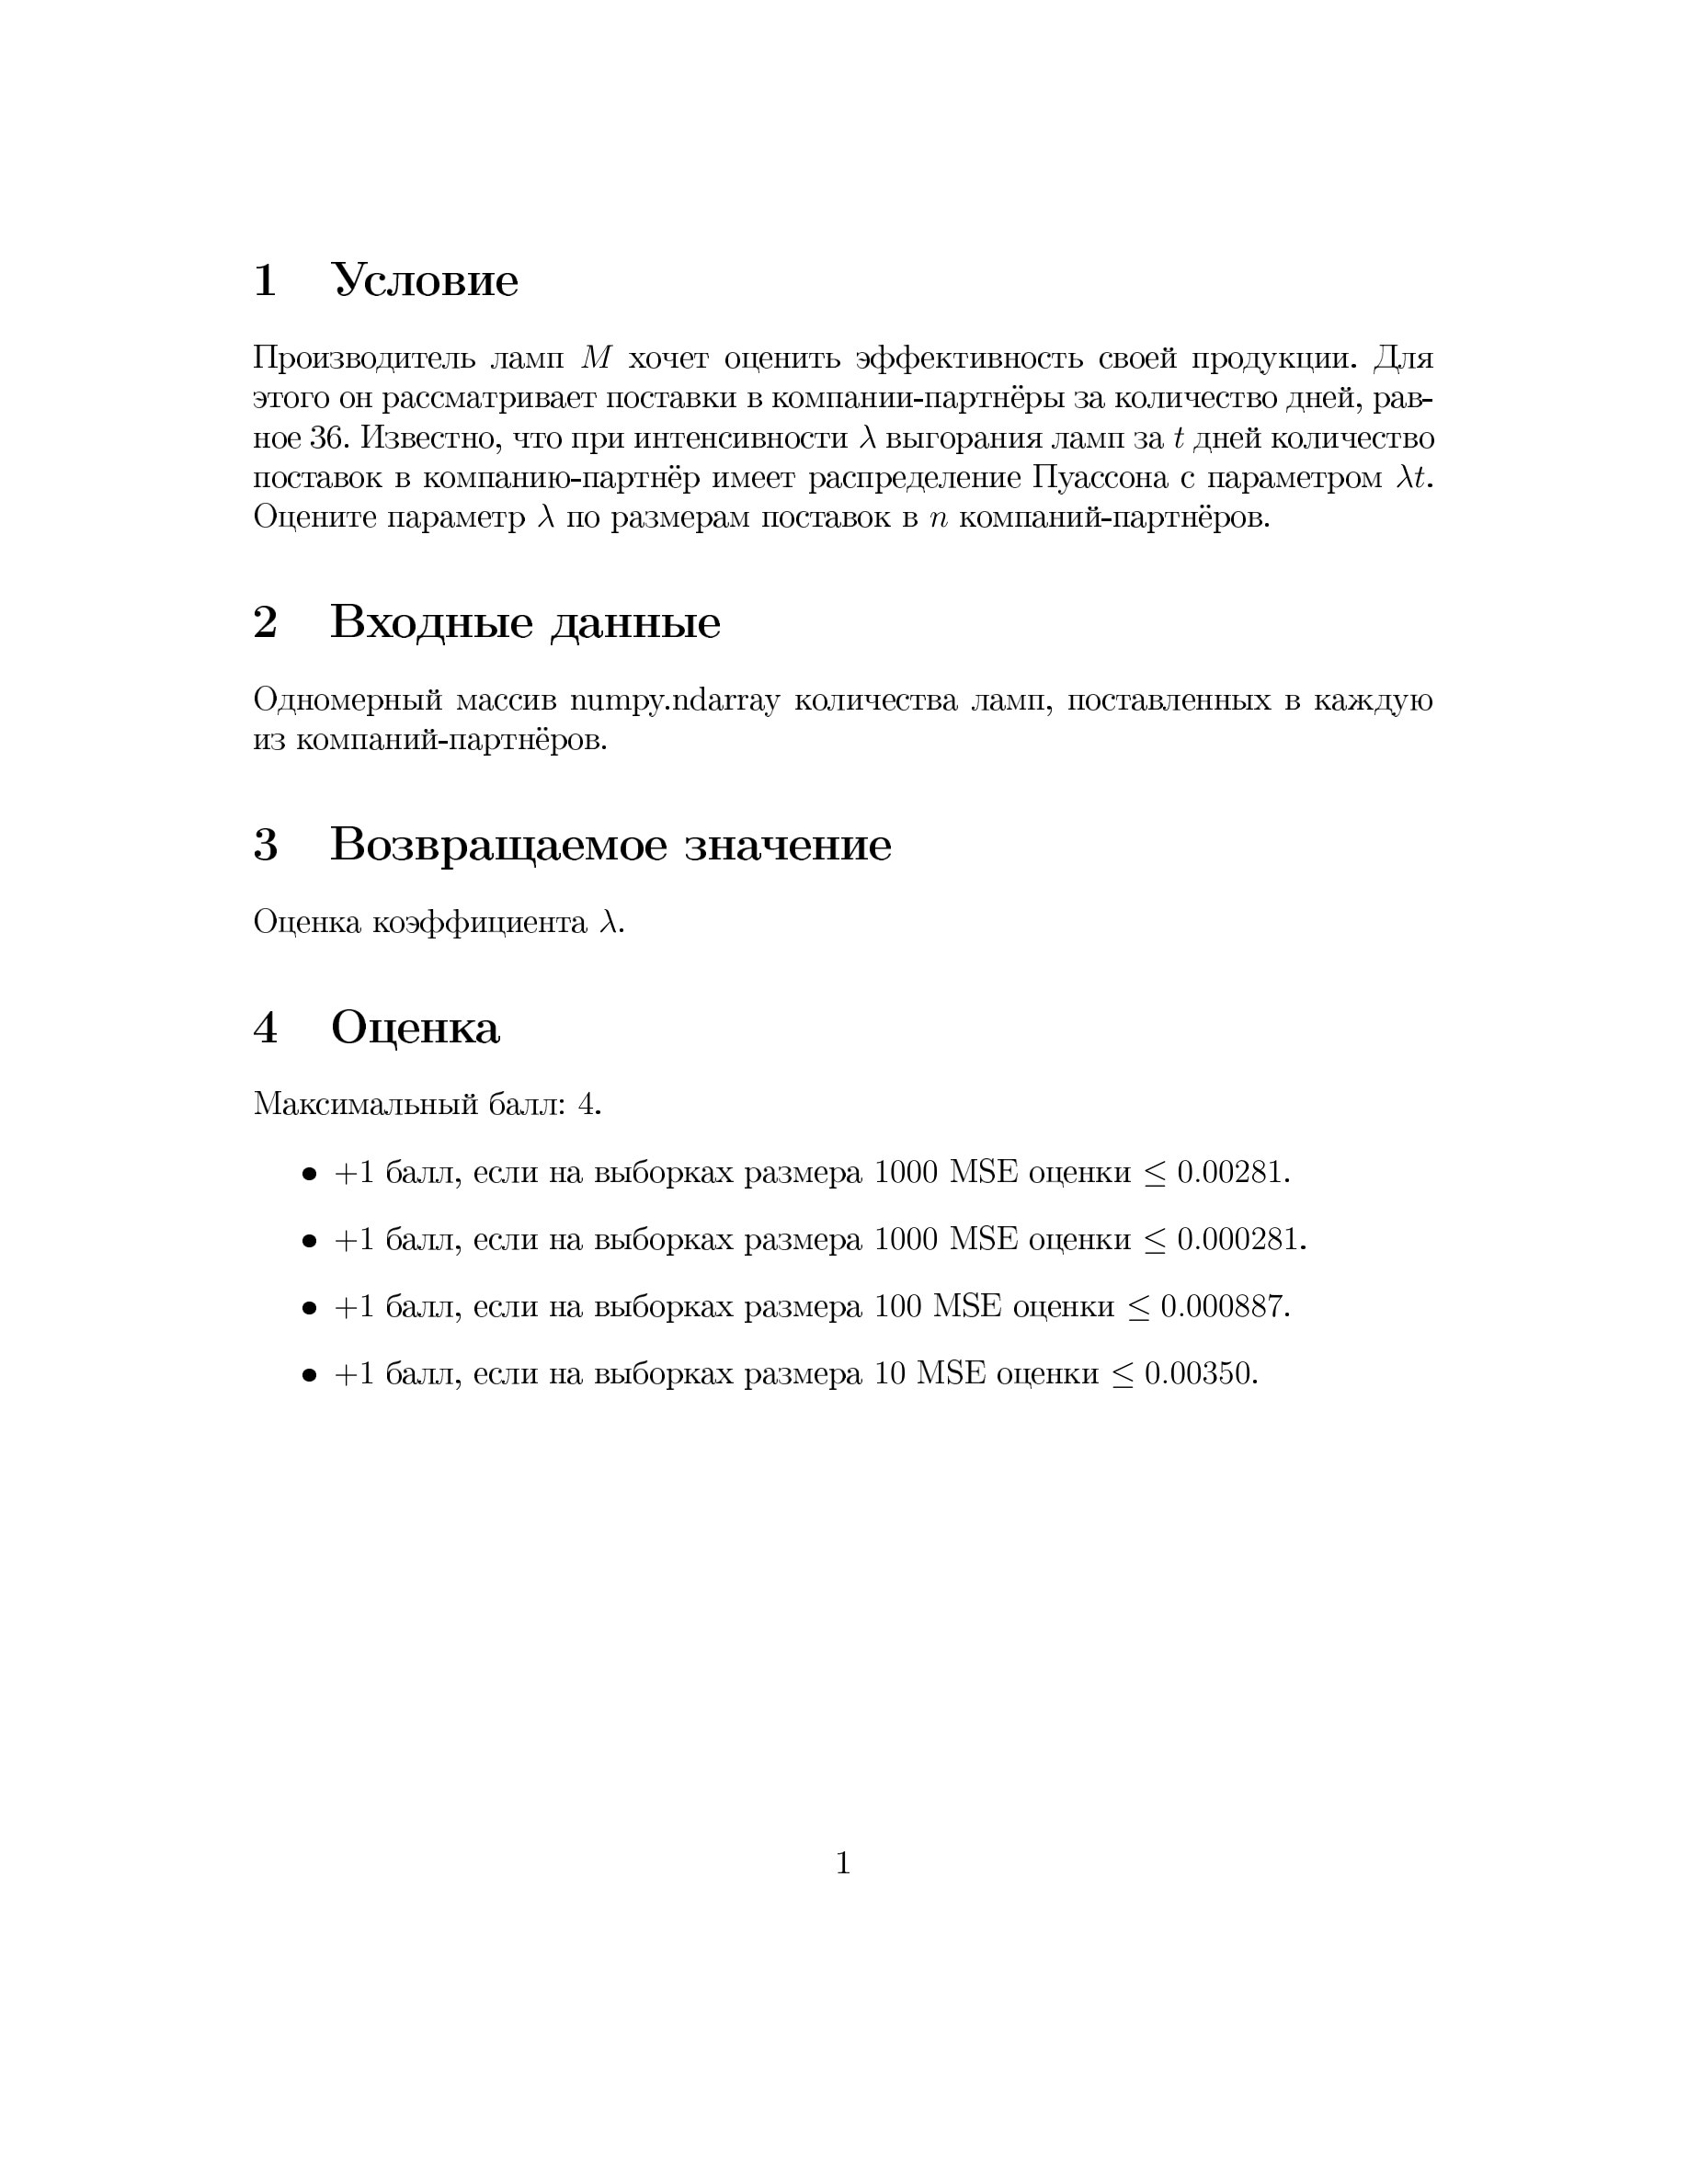

Пусть $X_1$,..., $X_n$ - количество поставок в компании-партнеры, тогда $X_i \sim Poisson(36L)$. Связав матожидание с оцениваемым параметром имеем $EX_1 = 36L$. 

Таким образом: $EX_1 = g(L)$, где: $g(L) = 36L$, $g^{-1}(x) = x / 36$.

В итоге: $g^{-1}(\bar{X}) = \bar{X} / 36$.

In [2]:
def solution(x: np.array) -> float:
    # Измените код этой функции
    # Это будет вашим решением
    # Не меняйте название функции и её аргументы
    mean_count = np.mean(x)
    t = 36
    L = mean_count / t
    return L

## 2 задание
Общее описание

В этом домашнем задании вам нужно будет построить интервальную оценку в модели, зависящей от вашего варианта. Ответом является функция, вычисляющая по уровню доверия и выборке интервальную оценку. В зависимости от точности вашей оценки будет зависеть количество баллов, полученное за ДЗ.

Условие задачи:
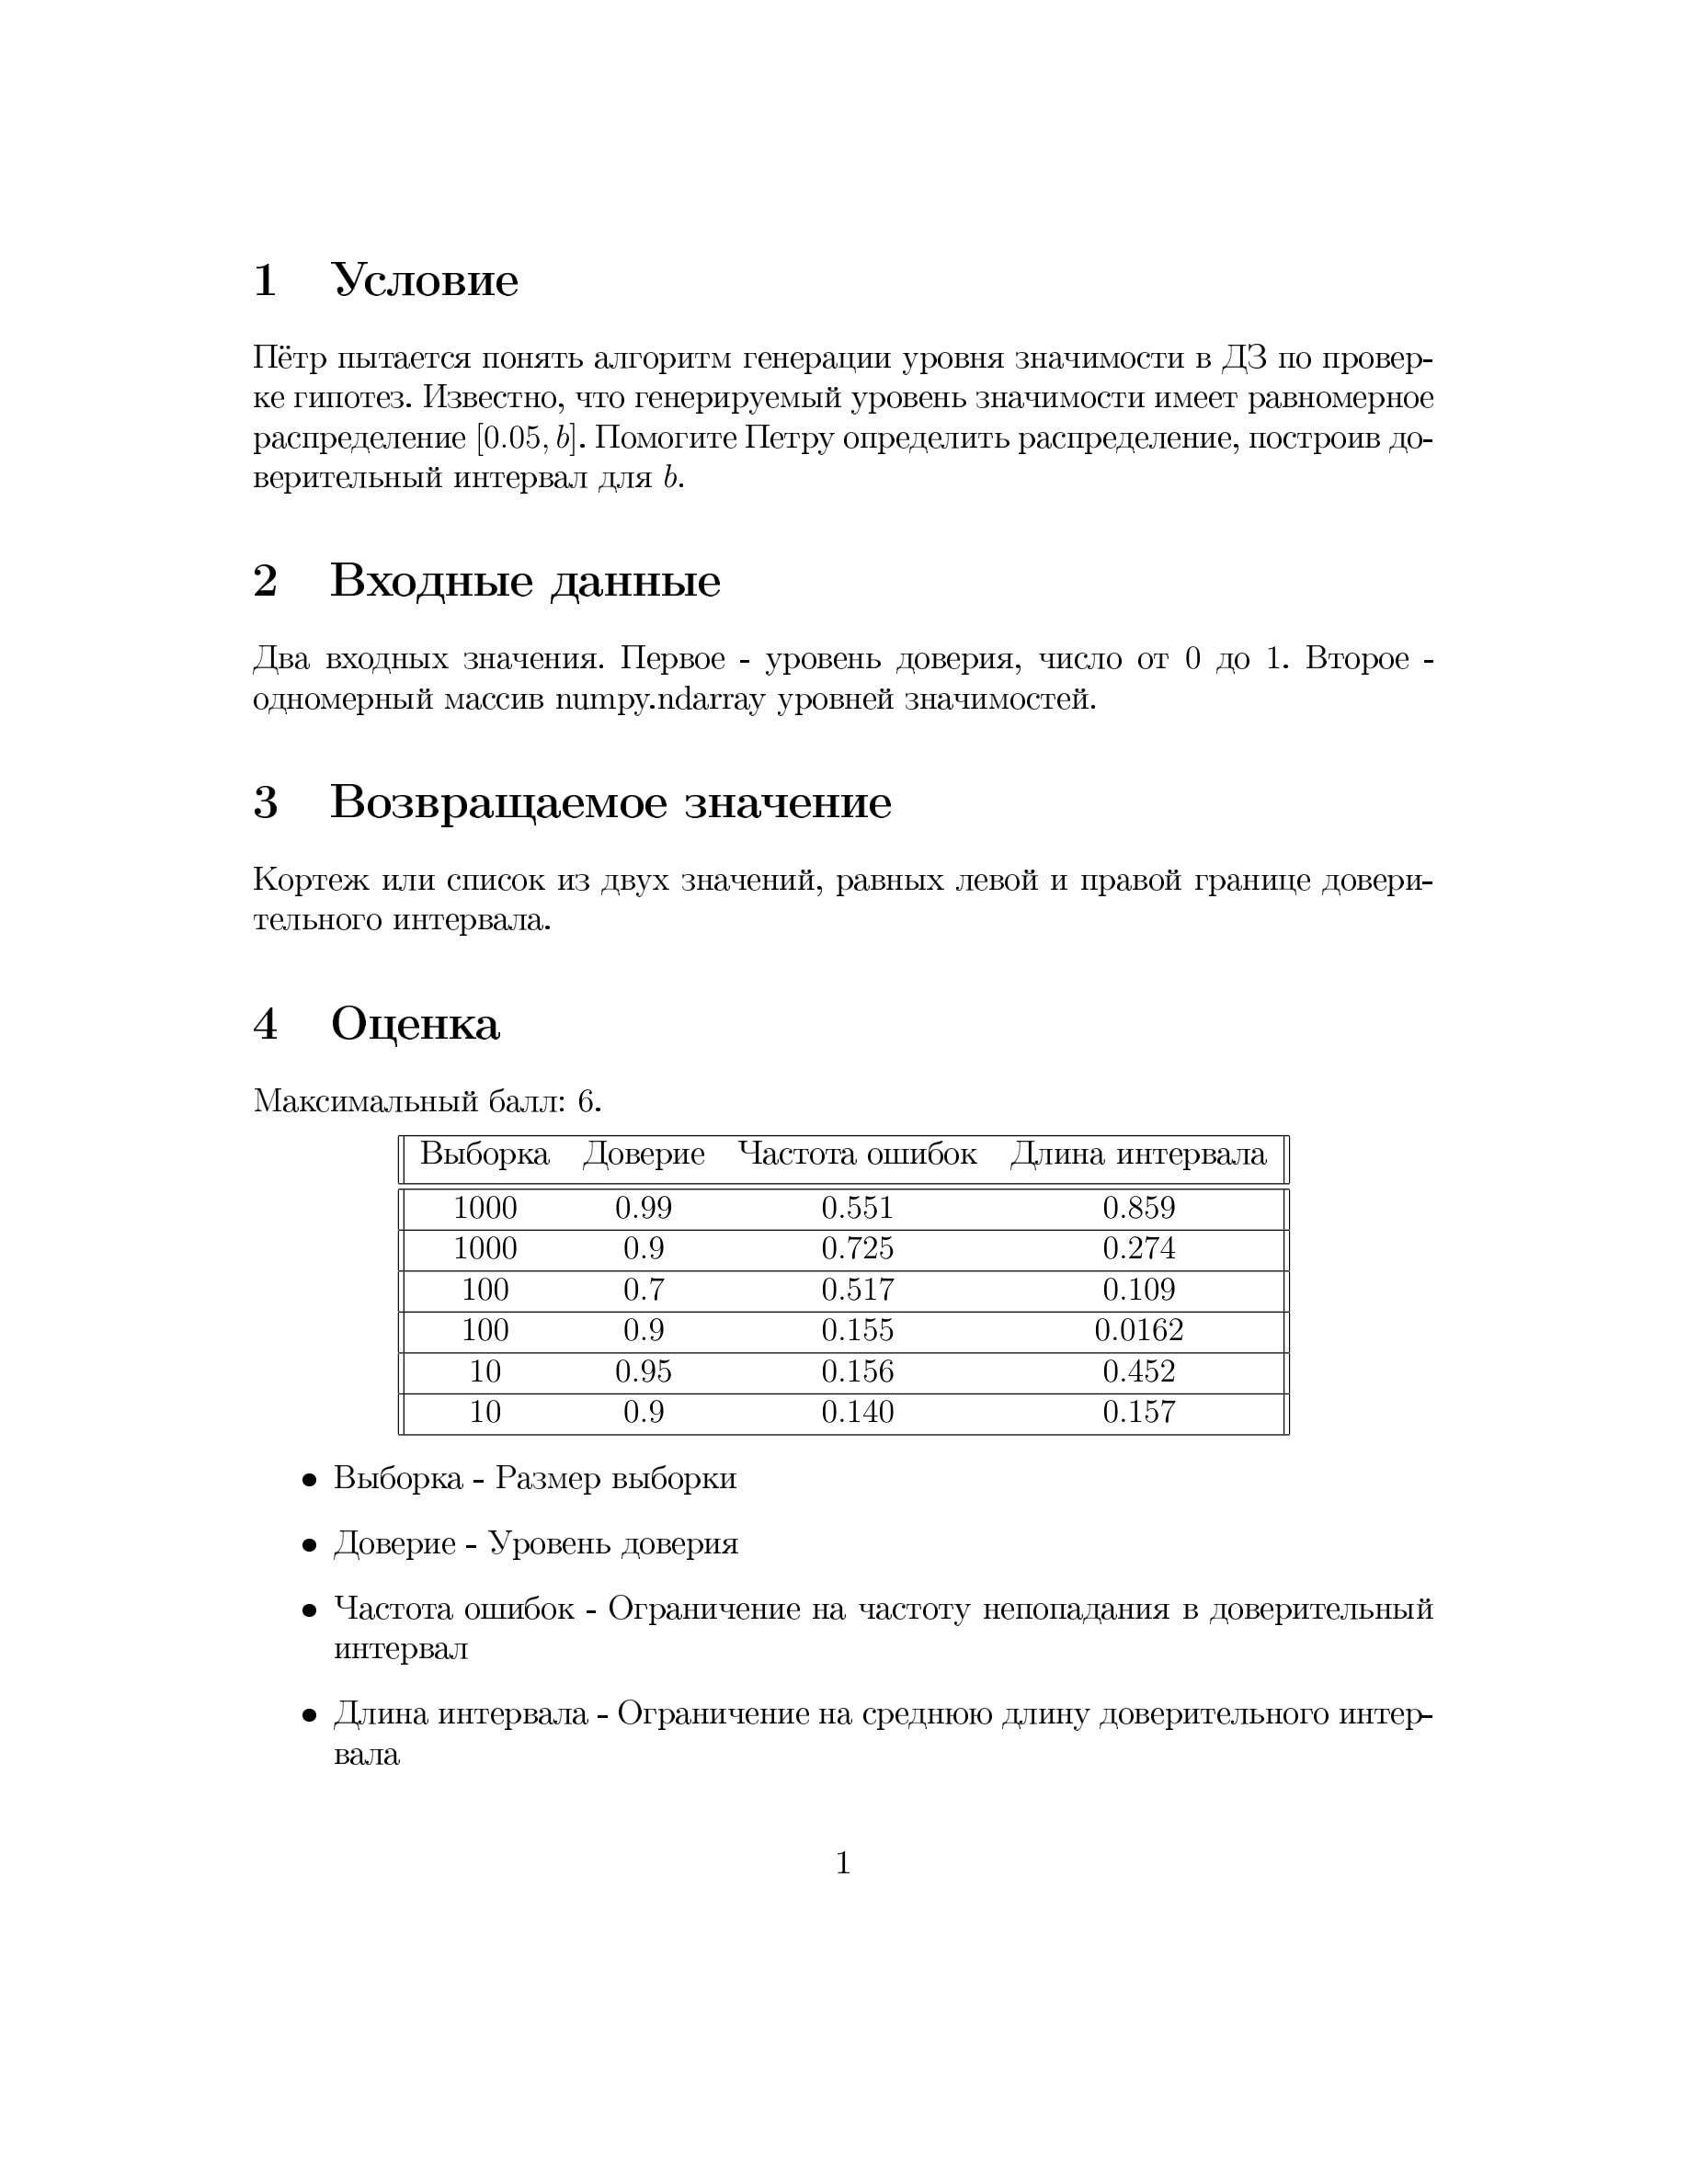

In [3]:
def solution(p: float, x: np.array) -> tuple:
    # Измените код этой функции
    # Это будет вашим решением
    # Не меняйте название функции и её аргументы
    alpha = 1 - p
    loc = np.max(x)
    left = loc
    right = loc/(alpha**(1/len(x)))
    return left,right 

## 3 задание

Общее описание

В этом домашнем задании вам нужно будет построить критерий, определяющий по данным эксперимента решение. Ответом является функция, вычисляющая по выборке bool-значение. В зависимости от корректности вашего критерия будет зависеть количество баллов, полученное за ДЗ.

Условие задачи:
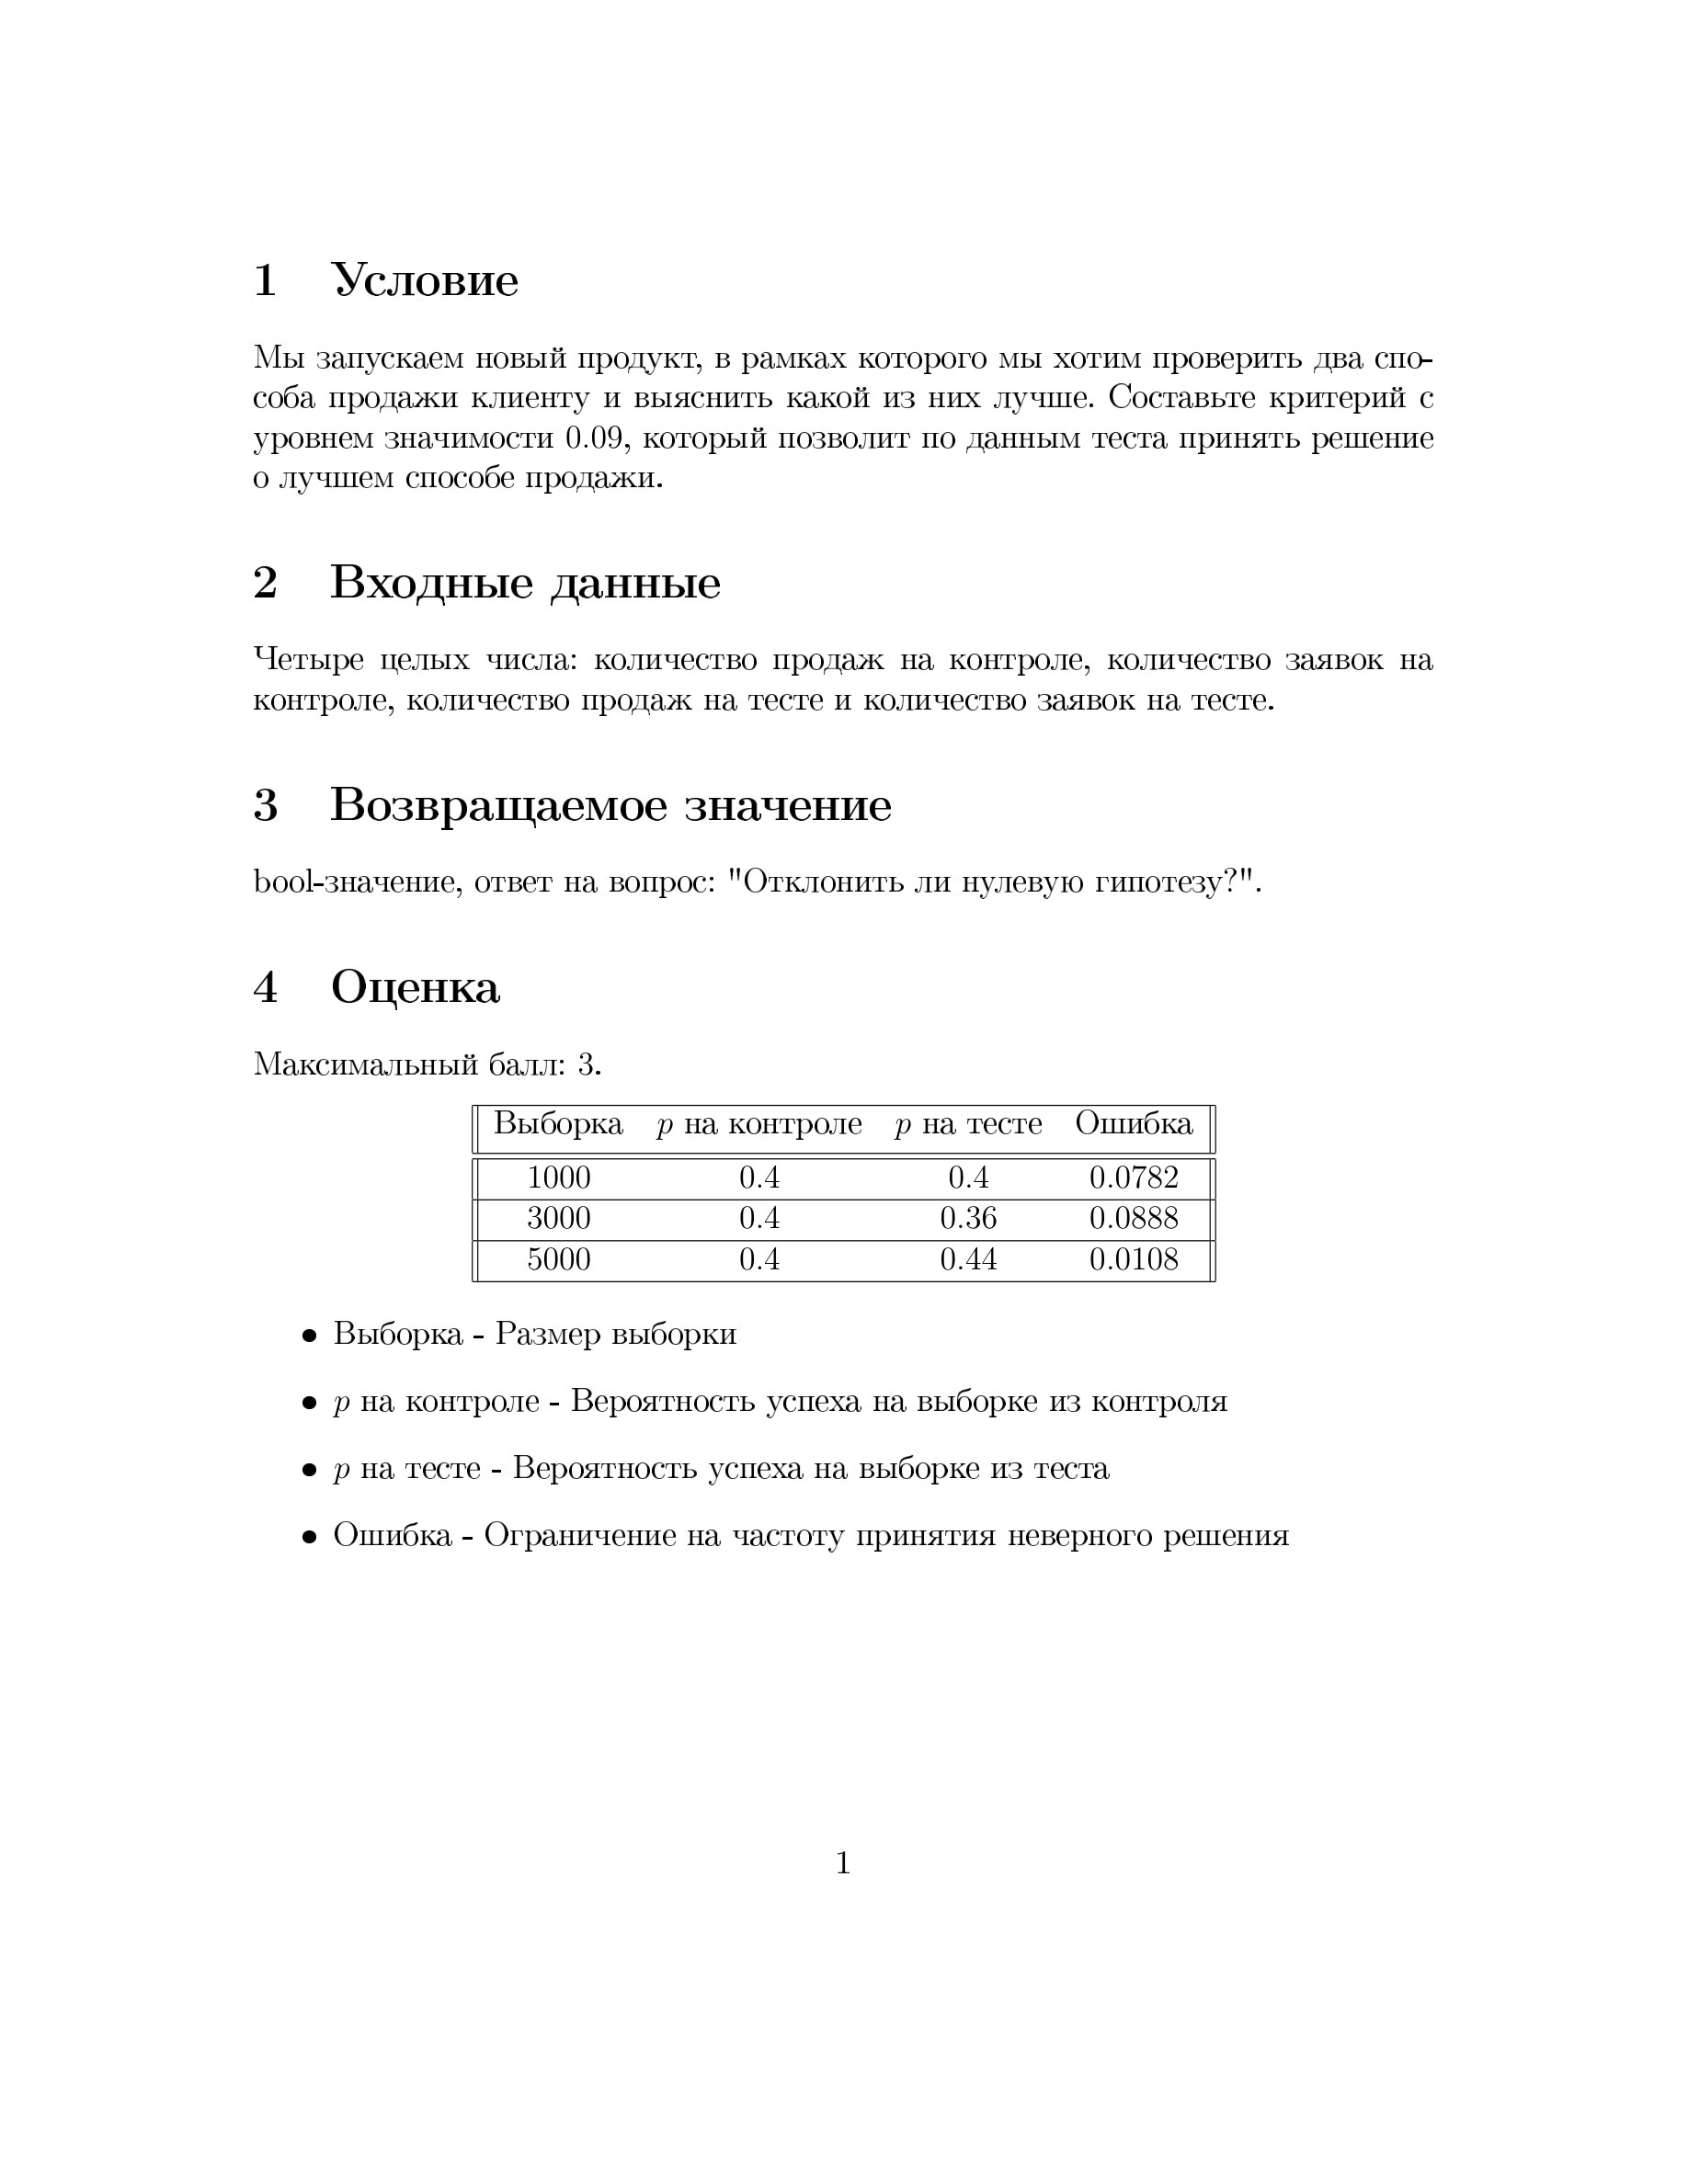

Нужно определить лучшую стратегию продажи. В этом случае:

$H_0: p_c = p_t$

$H_1: p_c \neq p_t$

Где: $p_c$ - конверсия на контроле, $p_t$ - конверсия на тесте. 

Для проверки гипотезы равенства конверсий используется proportions_ztest.

In [4]:
def solution(x_success: int, 
             x_cnt: int, 
             y_success: int, 
             y_cnt: int) -> bool:
    # Измените код этой функции
    # Это будет вашим решением
    # Не меняйте название функции и её аргументы
    alpha = 0.09
    _, p_value = proportions_ztest([x_success, y_success], [x_cnt, y_cnt], alternative='two-sided')
    return p_value < alpha

## 4 задание

Общее описание

В этом домашнем задании вам нужно будет построить критерий, проверяющий однородность одномерных выборок. Ответом является функция, вычисляющая по выборке bool-значение. В зависимости от корректности вашего критерия будет зависеть количество баллов, полученное за ДЗ.

Условие задачи:
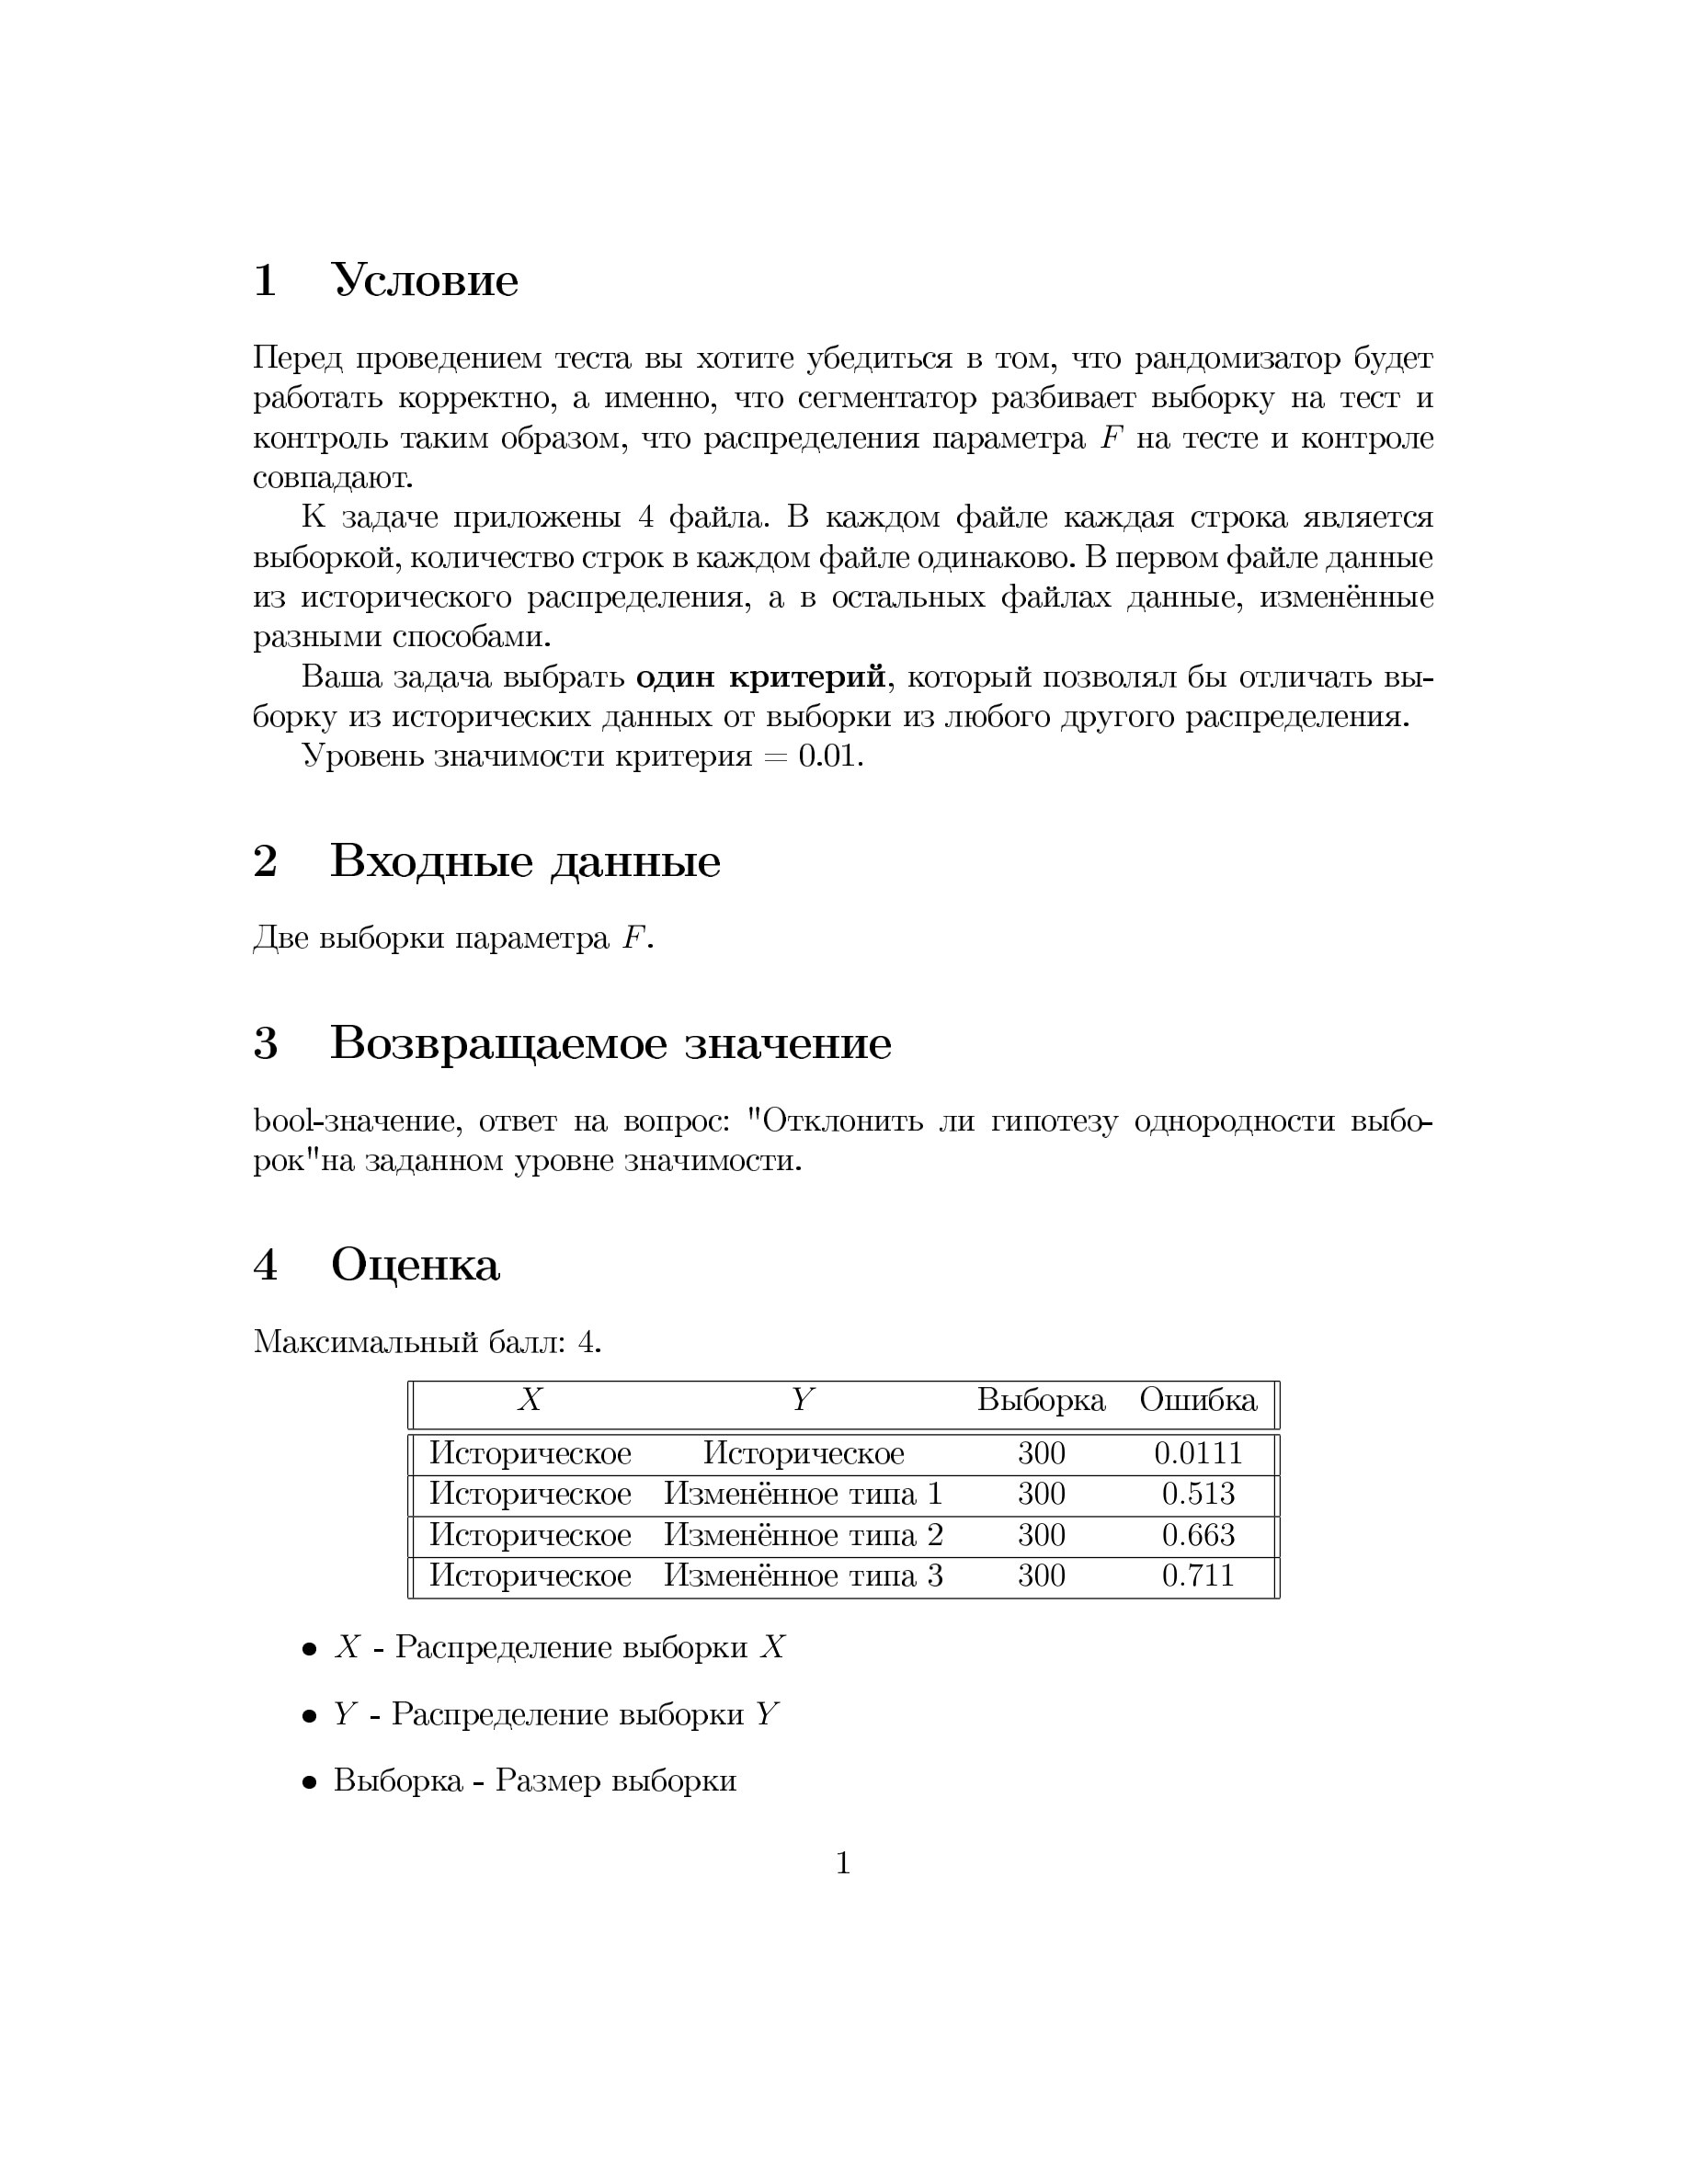

In [5]:
# загрузим данные, которые получили от бота

historical_data = pd.read_csv("historical_data.csv")
modified_data_of_type_1 = pd.read_csv("modified_data_of_type_1.csv")
modified_data_of_type_2 = pd.read_csv("modified_data_of_type_2.csv")
modified_data_of_type_3 = pd.read_csv("modified_data_of_type_3.csv")

In [6]:
# смоделируем p_value, чтобы выбрать лучший критерий

data_list = [{
    "x": historical_data[::2],
    "y": historical_data[1::2],
    "dist_desc": "Историческое VS Историческое"
}, {
    "x": historical_data,
    "y": modified_data_of_type_1,
    "dist_desc": "Историческое VS Изменённое типа 1"
}, {
    "x": historical_data,
    "y": modified_data_of_type_2,
    "dist_desc": "Историческое VS Изменённое типа 2"
}, {
    "x": historical_data,
    "y": modified_data_of_type_3,
    "dist_desc": "Историческое VS Изменённое типа 3"
}]

test_list = [{
    "p_value": lambda x, y: ks_2samp(x, y, alternative="two-sided").pvalue,
    "name": "Kolmogorov-Smirnov"
},  {
    "p_value": lambda x, y: cramervonmises_2samp(x, y).pvalue,
    "name": "CVM"
}, {
    "p_value": lambda x, y: Energy(compute_distance="euclidean").test(x, y)[1],
    "name": "Energy with euclidean metric"
}, {
    "p_value": lambda x, y: MMD(compute_kernel="rbf", gamma=1/10).test(x, y)[1],
    "name": "MMD, rbf, gamma=0.1"
}, {
    "p_value": lambda x, y: MMD(compute_kernel="rbf", gamma=1).test(x, y)[1],
    "name": "MMD, rbf, gamma=1"
}, {
    "p_value": lambda x, y: MMD(compute_kernel="rbf", gamma=10).test(x, y)[1],
    "name": "MMD, rbf, gamma=10"
}]

for data in data_list:
    test_p_value_list = {
        test["name"]: []
        for test in test_list
    }

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.linspace(start=0, stop=1, num=1000), 
                             y=np.linspace(start=0, stop=1, num=1000),
                             mode="lines", name="y = x"))

    for i in range(data["x"].shape[0]):
        x = data["x"].iloc[i].to_numpy()
        y = data["y"].iloc[i].to_numpy()
        
        for test in test_list:
            test_p_value_list[test["name"]].append(test["p_value"](x, y))

    for test in test_list:
        p_value_ecdf = ECDF(test_p_value_list[test["name"]])
        fig.add_trace(go.Scatter(x=p_value_ecdf.x, y=p_value_ecdf.y,
                                 mode="lines", name=test["name"]))

    fig.update_layout(title=f"Сравнение различных методов для проверки однородности, {data['dist_desc']}",
                      xaxis_title="alpha",
                      yaxis_title="ЭФР p-value",
                      legend_title="Критерии")
    #fig.show() 

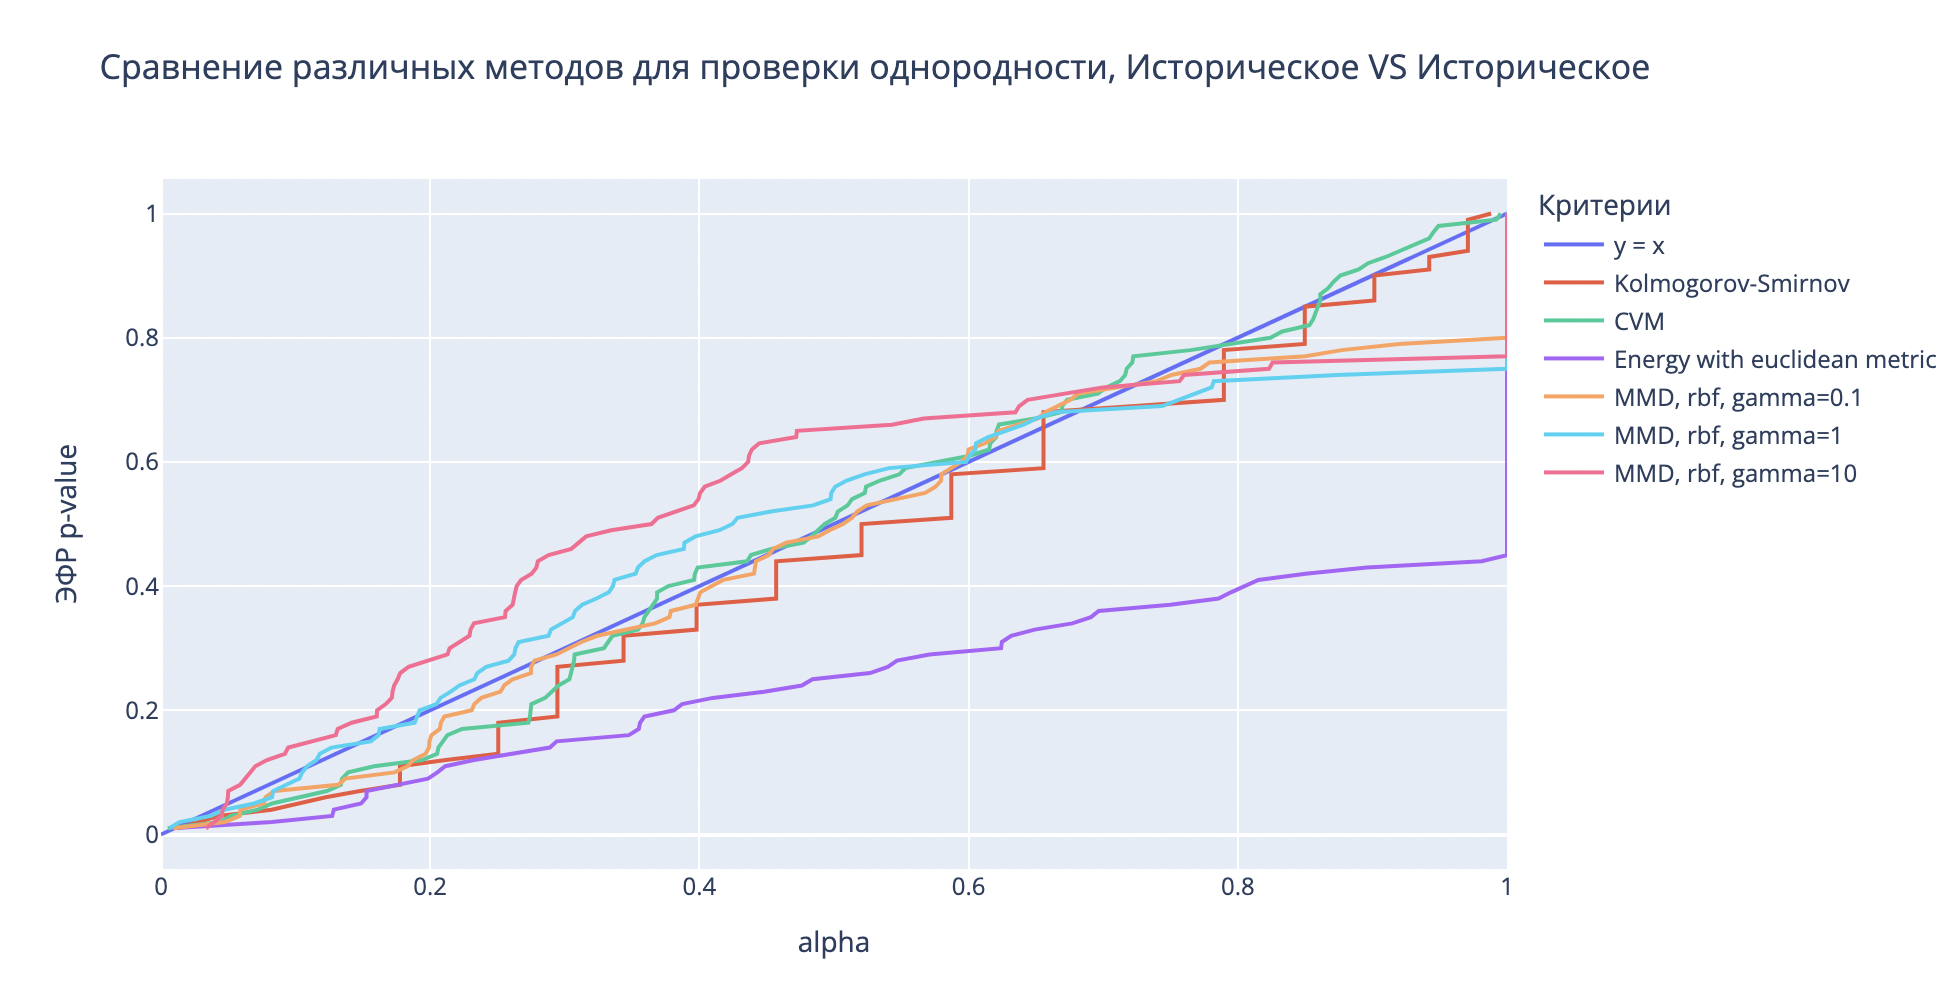
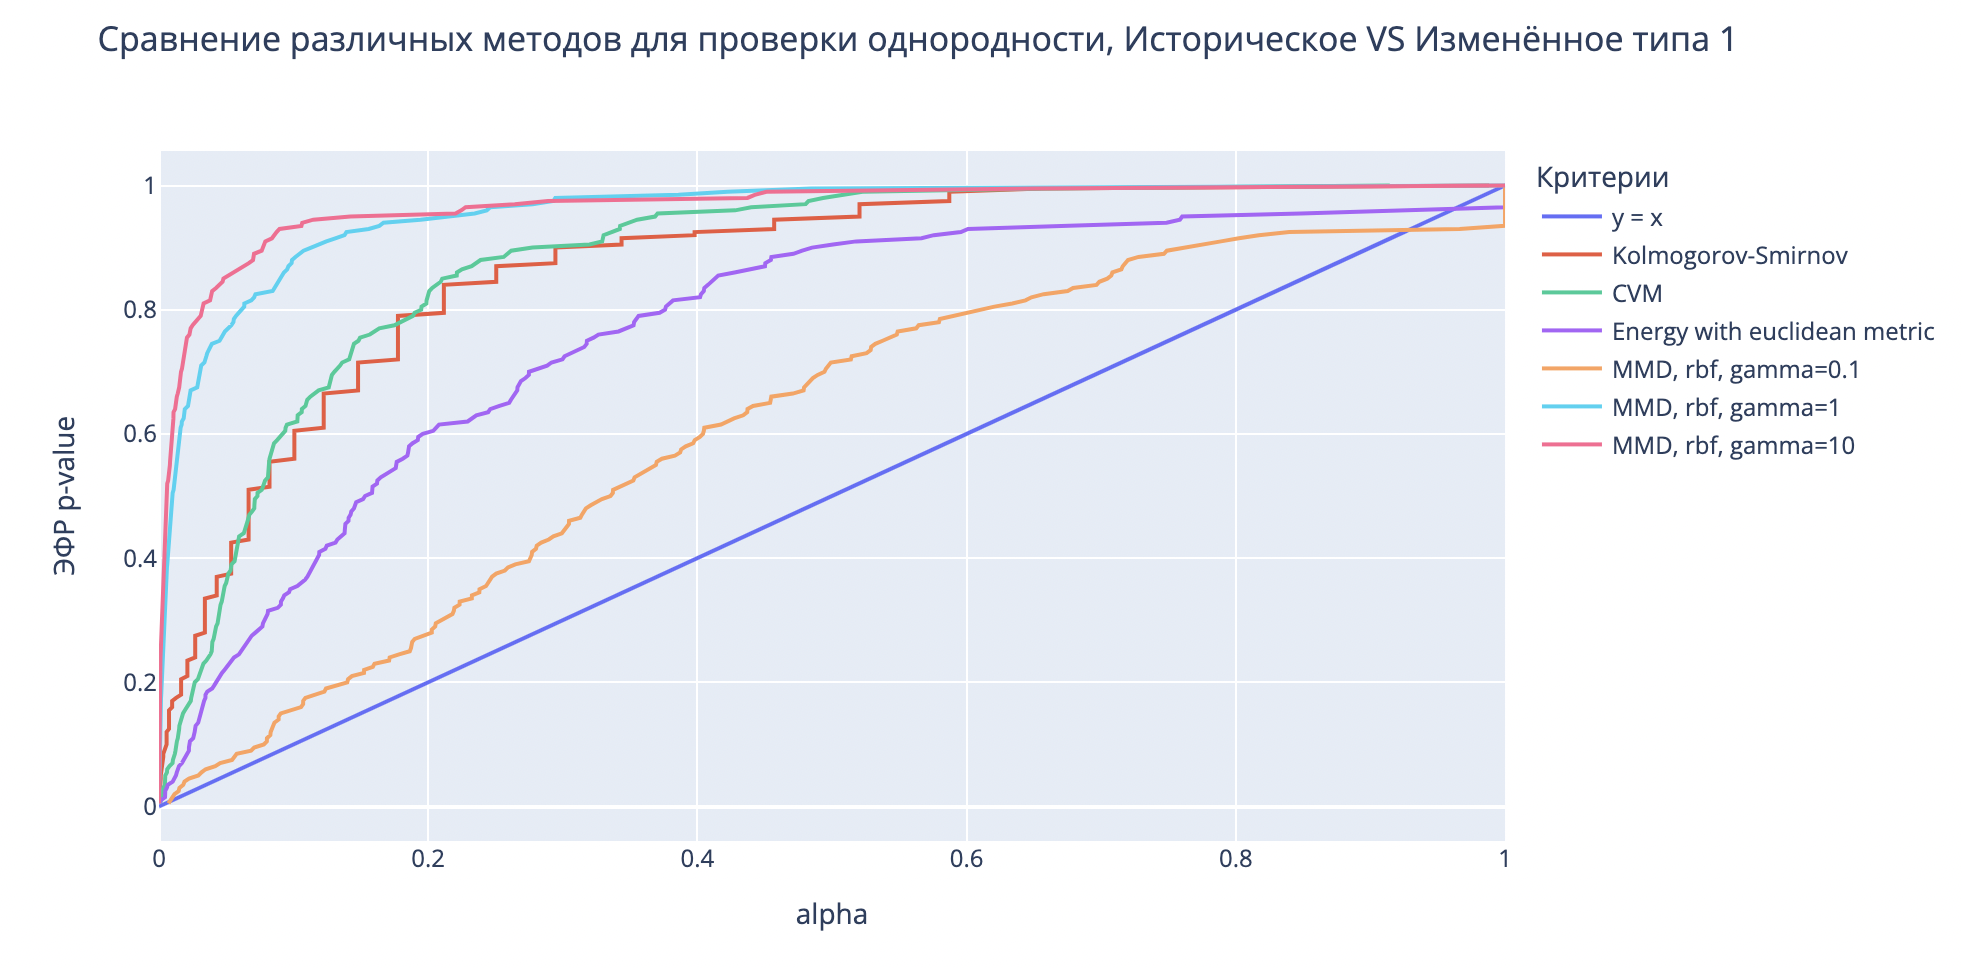
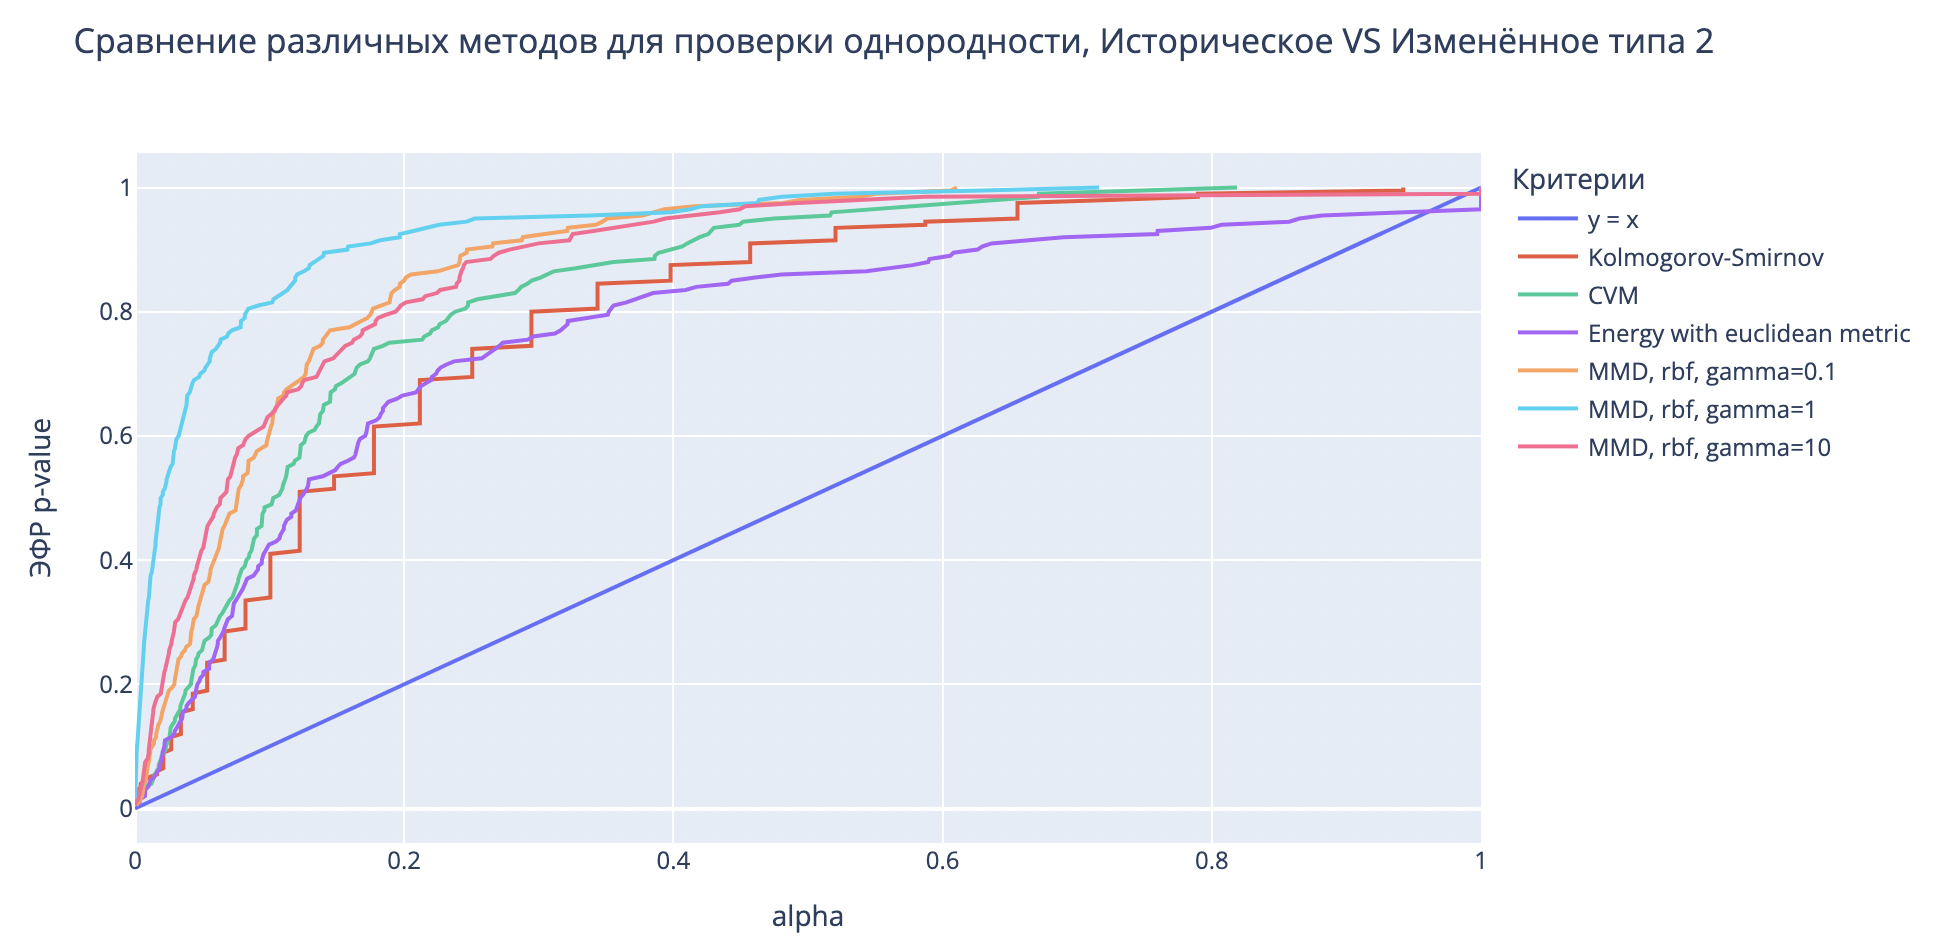
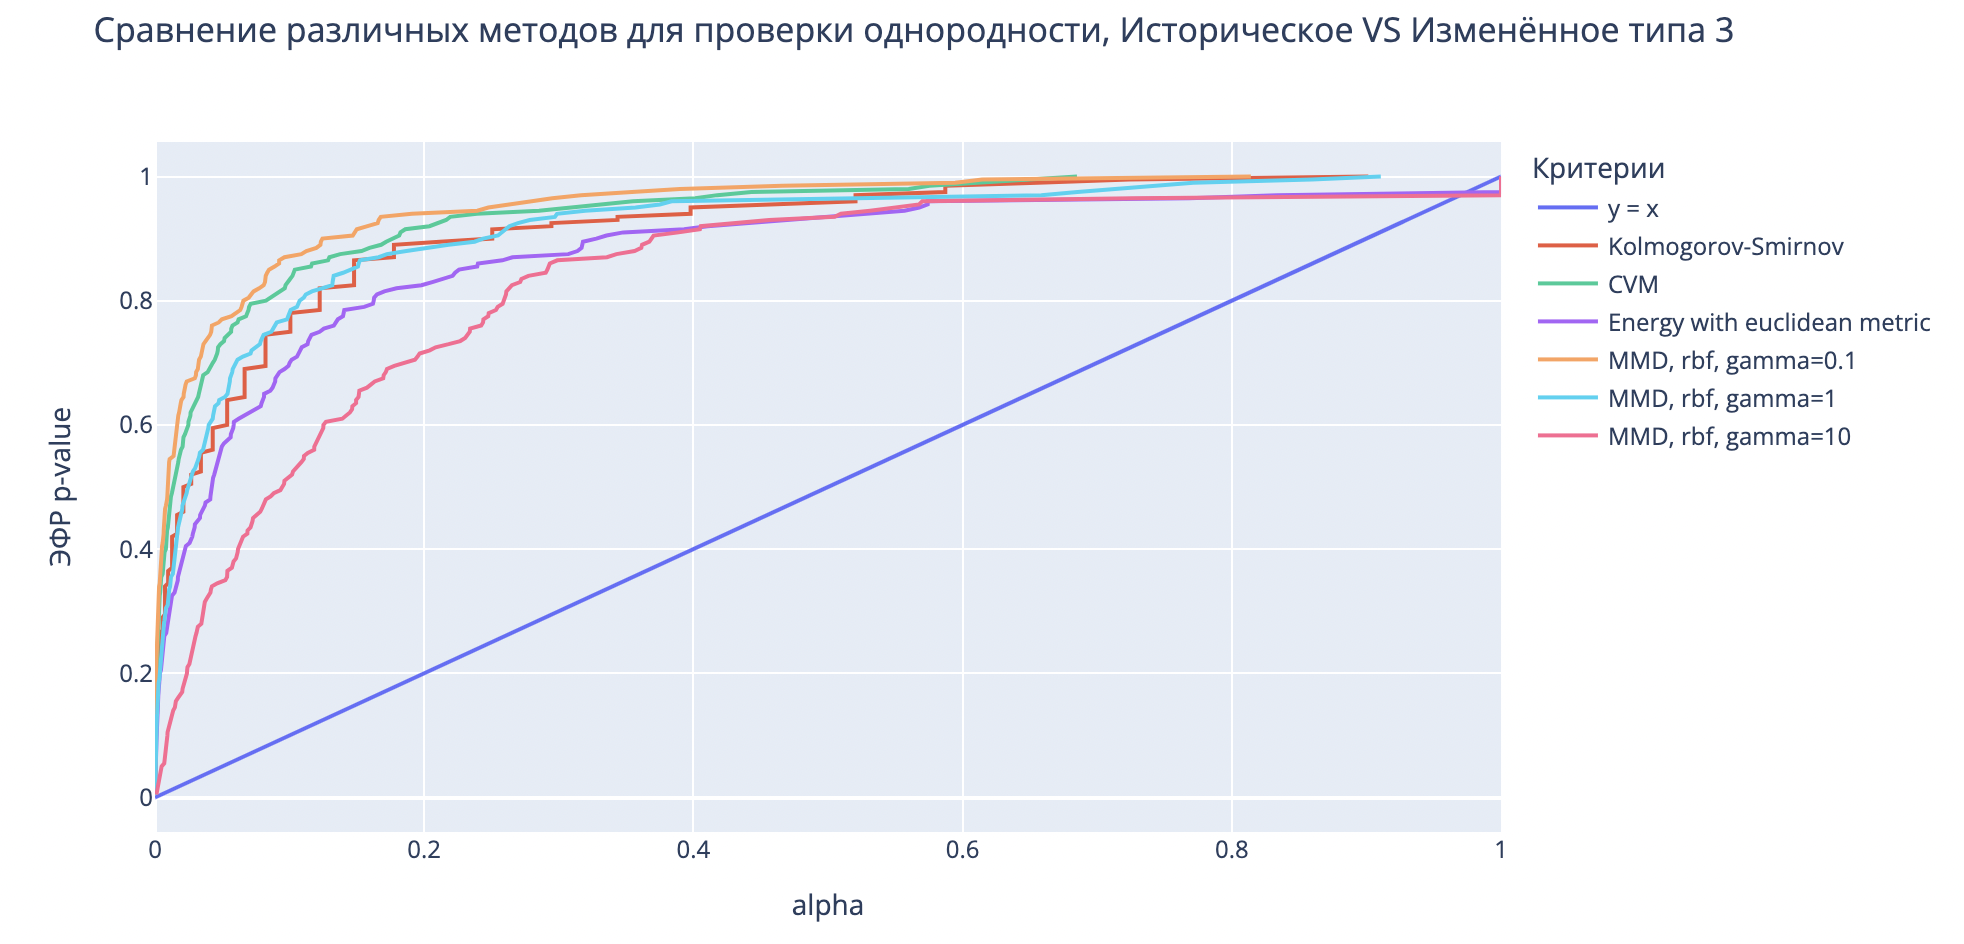

Лучший результат у "MMD, rbf, gamma=1", теперь напишем функцию.

In [7]:
def solution(x: np.array, y: np.array) -> bool:
    # Измените код этой функции
    # Это будет вашим решением
    # Не меняйте название функции и её аргументы
    # Проверяем гипотезу о том, что распределения на выборках x и y совпадают
    p_value = MMD(compute_kernel="rbf", gamma=1).test(x, y)[1]

    # Если p-уровень значимости меньше заданного уровня значимости, отклоняем гипотезу однородности выборок
    return p_value < 0.01

## 5 задание
Общее описание

В этом домашнем задании вам нужно будет построить критерий, проверяющий гипотезу по результатам проведения теста. Ответом является функция, вычисляющая по выборке bool-значение. В зависимости от корректности вашего критерия будет зависеть количество баллов, полученное за ДЗ.

Условие задачи
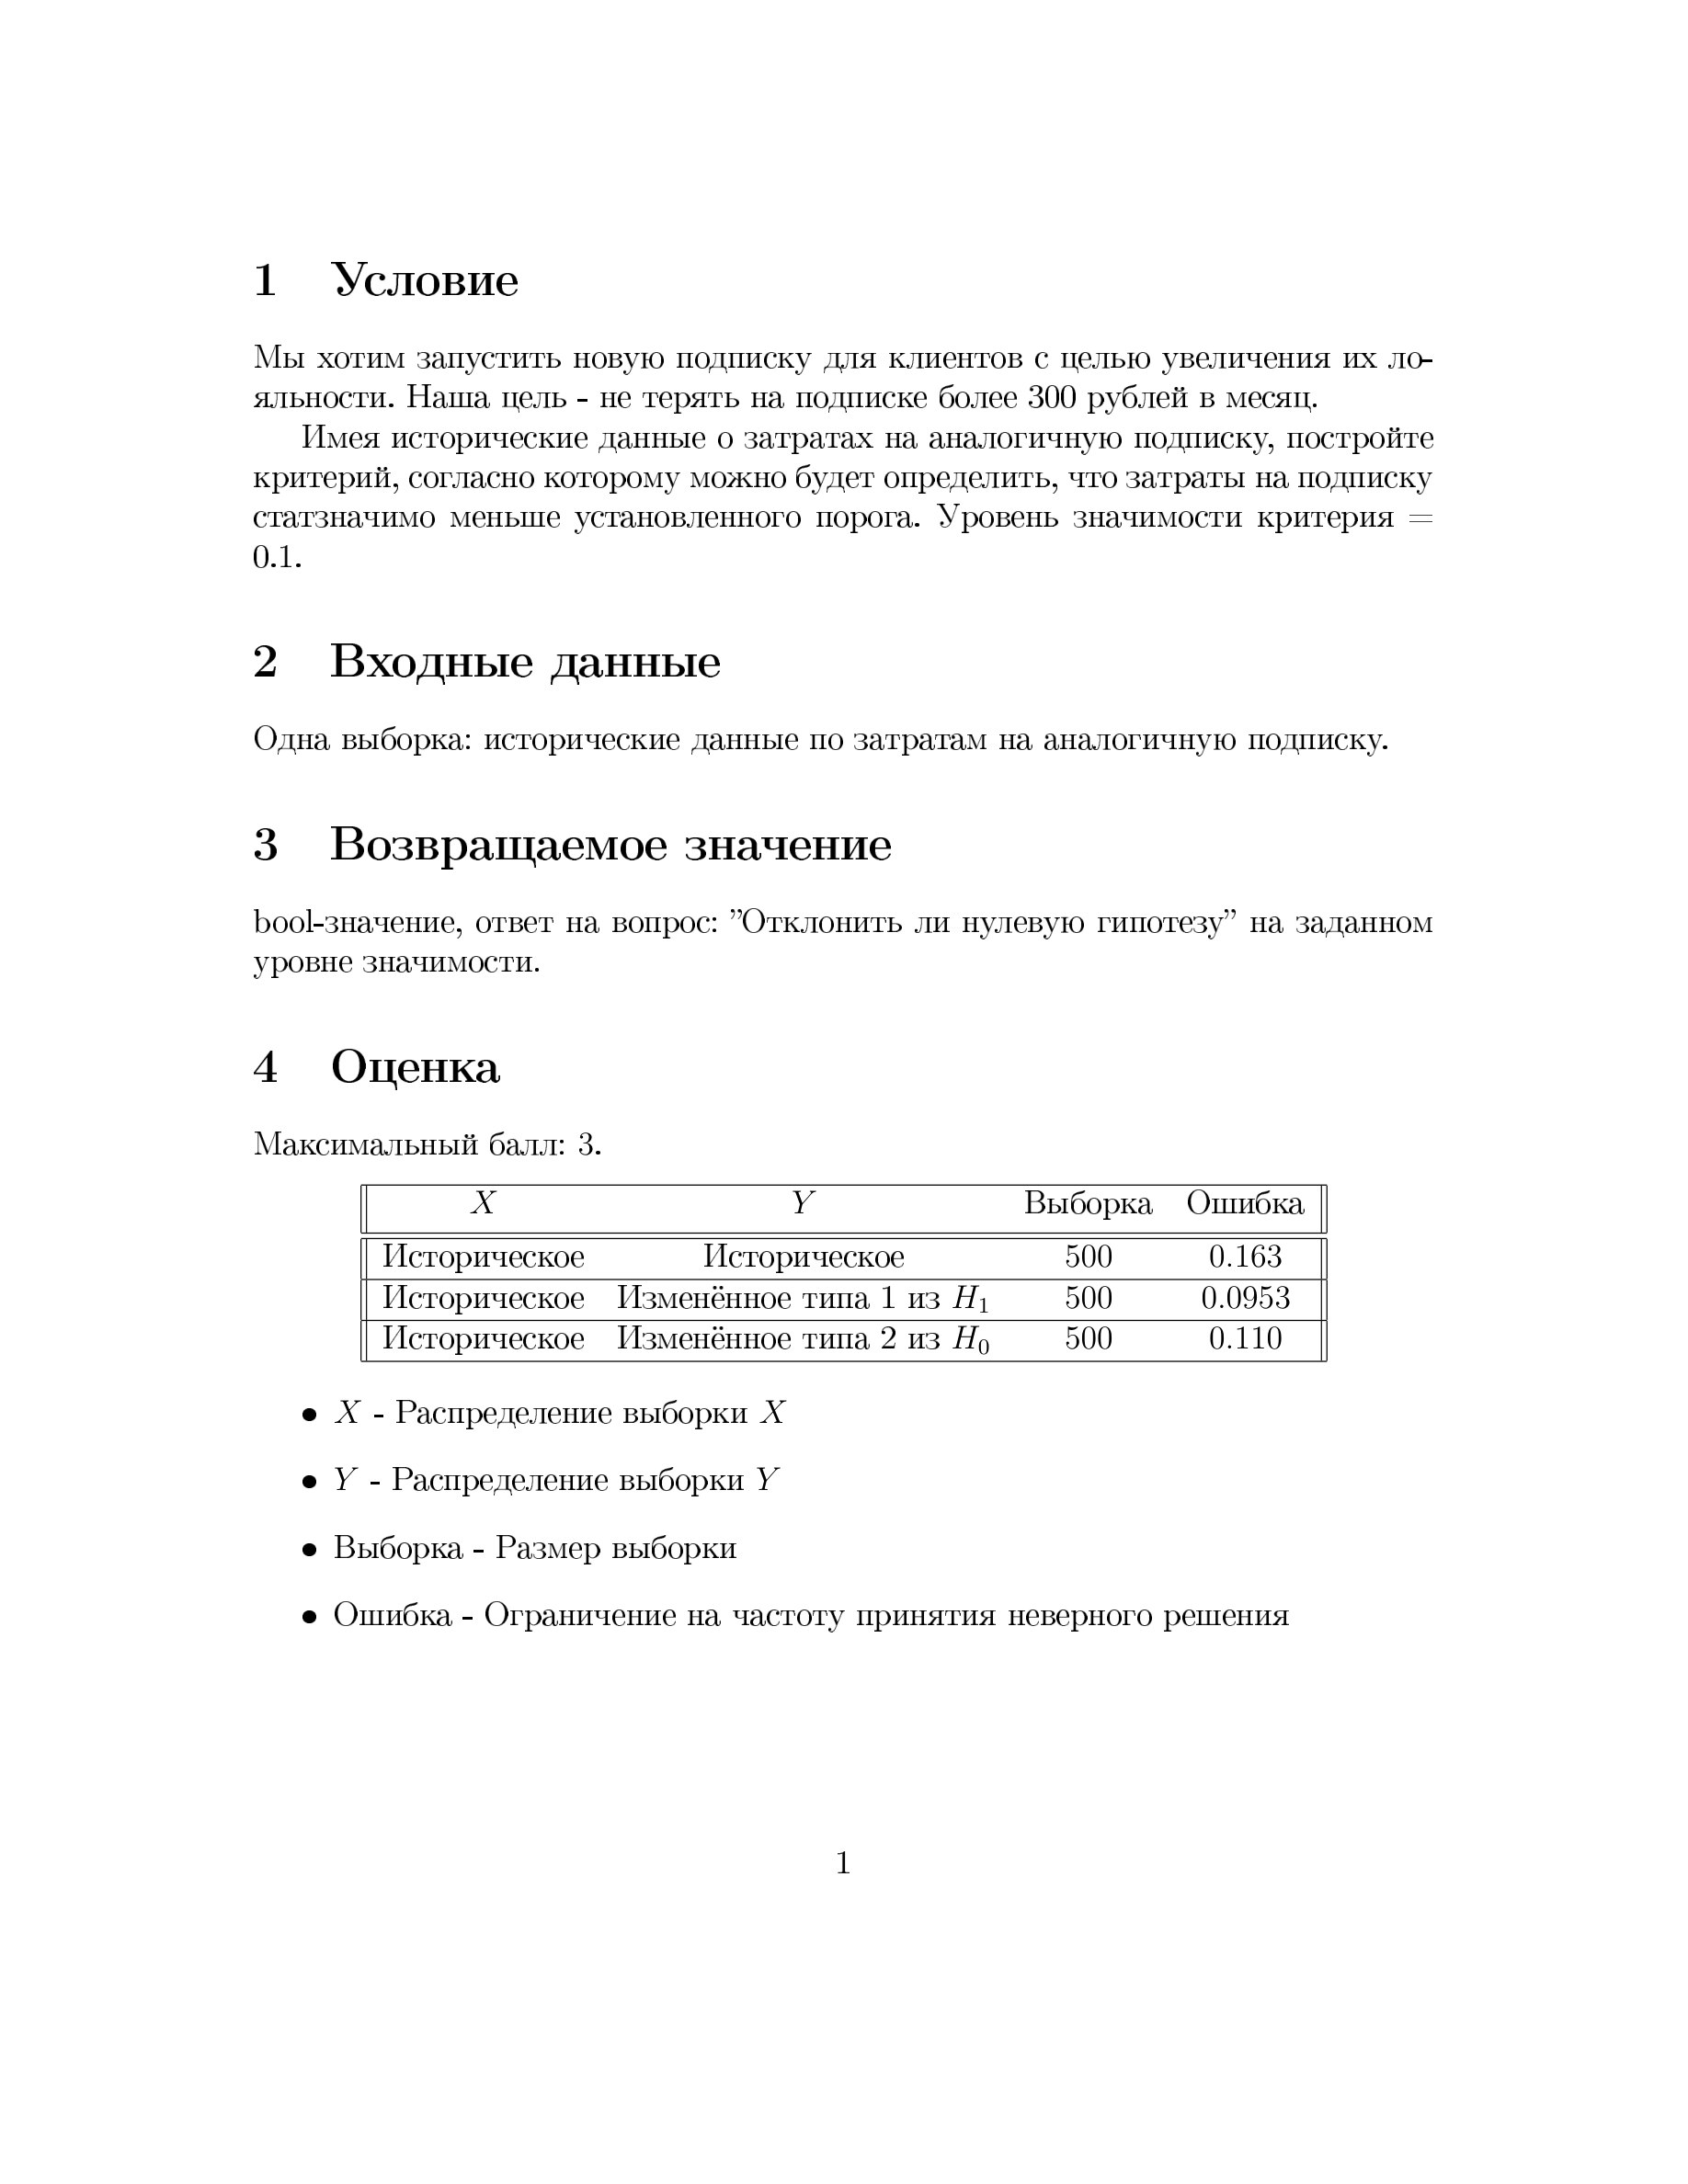

В этом случае:

$H_0: µ = value$

$H_1: µ < value$

Где: $value$ - заданное значение, $µ$ - среднее по выборке. 

Для проверки гипотезы равенства конверсий используется ztest.

In [8]:
def solution(data: np.array) -> bool: # Одна или две выборке на входе, заполняется исходя из условия
    # Измените код этой функции
    # Это будет вашим решением
    # Не меняйте название функции и её аргументы
    # Выполняем односторонний ztest
    _, p_value = ztest(data, 300, alternative='smaller')
    return p_value < 0.1

## Задание 6

Рассмотрим продукт Тинькофф Мобайл, который занимается продажей сим карт.

У продукта есть проблема: при выборе тарифа клиенты выбирают маленькие пакеты интернета, что является для продукта менее выгодным.

Предложите бизнес гипотезу и тест для решения этой проблемы, соответствующие целевую метрику, прокси метрики и контрольные метрики для выбранного вами теста.

**Решение**

Симулирование ситуации: есть 3 тарифа: “Старт”, “Стандарт”, “Безлимит”. Люди покупают тариф “Старт”, так как как он самый дешевый, что является невыгодным для компании. Цель - увеличить покупку тарифа “Стандарт” вместо “Старт”, чтобы увеличить Revenue.

Некоторые фундаментальные истины о потенциальных клиентах:
- Они не читают, они сканируют.
- Никто не любит сложные вещи. Никто не любит разбираться в вещах.
- Люди предпочитают то, что легко понять.
- Большинство клиентов не знает сколько Гб интернета им надо, поэтому они выбирают самый дешевый тариф. Необходимо проработать страницу с тарифами. 

Лучший способ показать клиентам их варианты — показать сравнительную таблицу. Идеальный размер для сравнительной таблицы - не более страницы. Если потенциальным клиентам приходится постоянно прокручивать страницу, чтобы увидеть информацию, им будет сложно отследить, какой вариант им больше всего нравится. Это слишком сложно для обработки, и будет сложно получить конверсию.
В первой строке таблицы укажем цену. Очевидно и прозрачно, сколько будет стоить каждый вариант. После этого в таблице перечислим функции. Сравнительная таблица показывает, имеет ли каждая ценовая категория указанную функцию/преимущество. 

Добавим пояснительную информацию, на сколько в среднем хватит Гб каждого тарифного плана в минутах прослушивания музыки / просмотра видео и т. д. Так люди будут ориентироваться не только на цены. 

Поможем клиенту выбрать выгодный для компании план - выделим лучший выбор. Предложение “Стандарт” выделим цветом, а остальные варианты сделаем серыми. Контрастный цвет бросается в глаза покупателю больше, чем серый.

Вывод: необходимо донести ценность пользователям выгодного для компании тарифа; сделать цены на продукты простыми, а страницу с тарифами — понятной. 

**Гипотеза:** Если Лиды будут заходить на новую страницу с тарифами, то они будут чаще активировать сценарий с покупкой пакета “Стандарт” (а не “Старт”), что увеличит Revenue компании. 

Группе А показываем старую страницу с тарифами, Группе В показываем новую страницу, предполагаем, что конверсия в покупку тарифа “Стандарт” в группе В будет статистически значимо выше, чем в группе А. Ошибка первого рода - 5%, мощность теста - 80%. 
Для проверки будем применять **proportions_ztest с правосторонней альтернативой**.


**Целевая метрика** - Revenue. 

**Прокси метрики:**
- Конверсия в покупку тарифа “Стандарт” 
- Средний чек покупки тарифа (Average check). 

**Контрольные метрики:**
- Общая конверсия в покупку тарифа (Итоговая конверсия в покупку тарифа не должна упасть) 
- Конверсия в покупку тарифа “Безлимит”. 